In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from validation_utils import *
from sklearn.calibration import IsotonicRegression

In [3]:
# Load and process data
pd.set_option('display.max_columns', None, 'display.max_rows', 100)
data = pd.read_csv('../df_model_with_predictions2.csv', sep='\t')
data['year'] = data.admission_timestamp.apply(lambda s: datetime.strptime(s,'%Y-%m-%d %H:%M:%S').year)
data['length_of_stay'] = data['length_of_stay_hours']/24

In [4]:
# Relabel icu specialty variable
data['icu_specialty2'] = data['icu_specialty']
data.loc[data.icu_specialty=='cardio_surgery','icu_specialty2'] = 'surgery'
data.loc[data.icu_specialty=='surgery','icu_specialty2'] = 'surgery'
data.loc[data.icu_specialty=='neurosurgery','icu_specialty2'] = 'surgery'
data.loc[data.icu_specialty=='orthopedic_surgery','icu_specialty2'] = 'surgery'

In [5]:
# Generate table counting the cohort sizes
val_tab = temporal_validation_table(data)
val_tab.to_csv('../tables and figures/temporal_validation_design.csv')

In [6]:
# Generate table 1 per outcome
tab = table1(data, {'age':'cont','gender':'cat','icu_specialty2':'cat','length_of_stay':'cont'}, 
    {'all':[True]*data.shape[0], 
     'no event':data.y_true==False,
     'readmission':data.readmission_7d==True,
     'mortality':data.mortality_after_discharge_7d==True,
     'readmission and/or mortality':data.y_true==True})
tab.to_csv('../tables and figures/table1.csv')

In [7]:
# Generate table 1 per cohort
tab2 = table1(data, {'age':'cont','gender':'cat','icu_specialty2':'cat','length_of_stay':'cont',
    'readmission_7d':'cat','mortality_after_discharge_7d':'cat','readmission_or_mortality_after_discharge_7d':'cat'}, 
    {'all':[True]*data.shape[0], 
     '2016-2019':data.year>=2016,
     '2018-2019':data.year>=2018})
tab2.to_csv('../tables and figures/table1_years.csv')

In [8]:
# Recalibrate via isotonic regression
probabilities = {'pred_prob_vumc':[True]*data.shape[0],
    'interval_0':data.year>=2016,
    'interval_1':data.year>=2018,
    'pred_prob_lumc':[True]*data.shape[0]}

for m in probabilities:
    data[m+'_rescale'] = np.nan
    p = data.loc[probabilities[m],m]
    y = data.loc[probabilities[m],'y_true']
    isotonic = IsotonicRegression(out_of_bounds='clip',
                                y_min=p.min(),
                                y_max=p.max())
    isotonic.fit(p, y)
    data.loc[probabilities[m],m+'_rescale'] = isotonic.predict(p)

In [9]:
# Form validation data
val_dat = data.loc[:,['year','y_true','pred_prob_vumc','interval_0','interval_1',
    'pred_prob_lumc','pred_prob_vumc_rescale','interval_0_rescale','interval_1_rescale',
    'pred_prob_lumc_rescale']]

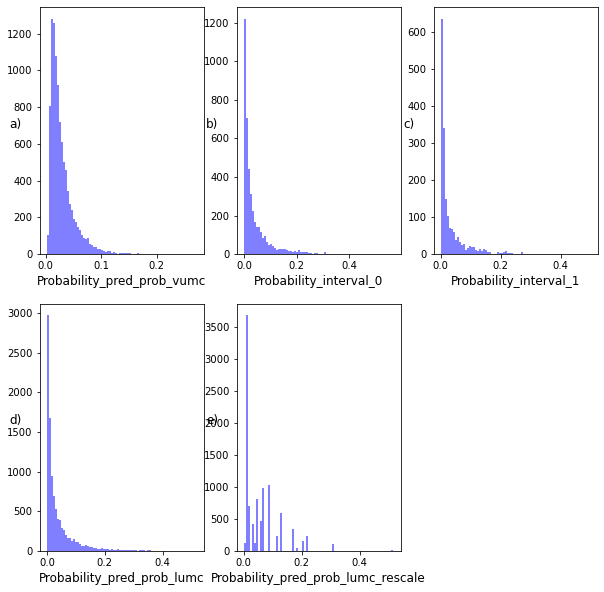

In [10]:
# Generate histograms and density plot
probabilities = {'pred_prob_vumc':[True]*val_dat.shape[0],
                 'interval_0':val_dat.year>=2016,
                 'interval_1':val_dat.year>=2018,
                 'pred_prob_lumc':[True]*val_dat.shape[0],
                 'pred_prob_lumc_rescale':[True]*val_dat.shape[0]}
hist = histogram_plot(val_dat, probabilities)
plt.savefig('../tables and figures/histogram.png')
# dens_plot = density_plot(val_dat, probabilities, title='validation step', 
#     labels=['before retraining','during retraining 1','during retraining 2','after retraining','after rescaling'])
# plt.savefig('../tables and figures/density plot.png')

In [34]:
# Generate predictive performance table
probabilities = {'pred_prob_vumc':[True]*val_dat.shape[0],
                 'interval_0':val_dat.year>=2016,
                 'interval_1':val_dat.year>=2018,
                 'pred_prob_lumc':[True]*val_dat.shape[0],
                 'pred_prob_vumc_rescale':[True]*val_dat.shape[0],
                 'interval_0_rescale':val_dat.year>=2016,
                 'interval_1_rescale':val_dat.year>=2018,
                 'pred_prob_lumc_rescale':[True]*val_dat.shape[0]}
y = 'y_true'
perf_tab = performance_table(val_dat, probabilities, y)
perf_tab.to_csv('../tables and figures/perf_tab.csv')

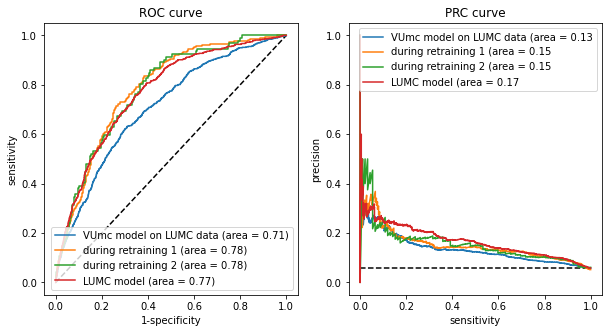

In [35]:
# Generate ROC & PRC curves
probabilities = {'pred_prob_vumc':[True]*val_dat.shape[0],
                 'interval_0':val_dat.year>=2016,
                 'interval_1':val_dat.year>=2018,
                 'pred_prob_lumc':[True]*val_dat.shape[0]}
y = 'y_true'
labels = {'pred_prob_vumc':'VUmc model on LUMC data',
          'interval_0':'during retraining 1',
          'interval_1':'during retraining 2',
          'pred_prob_lumc':'LUMC model'}
roc_prc_plot(val_dat, probabilities, y, labels=labels)
plt.savefig('../tables and figures/ROC_PRC.png')

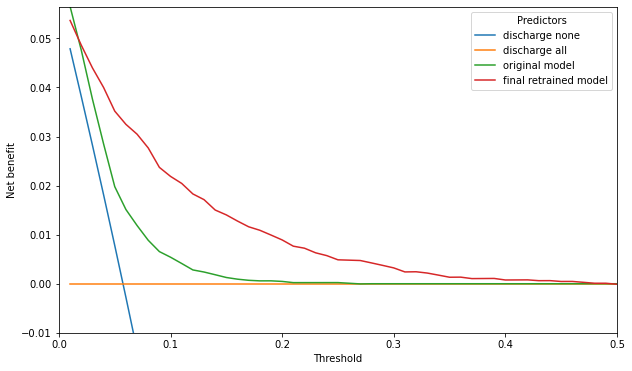

In [11]:
# Generate decision curve
probabilities = ['pred_prob_vumc','pred_prob_lumc']
labels = ['original model','final retrained model']
y = 'y_true'
decision_curve(val_dat, probabilities, y, labels, xlim=[0,0.5])
plt.savefig('../tables and figures/decision curve.png')